In [1]:
#This is a starting point
#uncomment below to install merlin library
#!pip install merlin, nvtabular, merlin.models
#I had to downgrade keras to 12.2.0 there maybe issues regarding tensorflow in the future
#run lines below if you have also have an error ab not finding a keras package

#pip uninstall keras
#pip install keras==2.12.0


#These are the same imports from
#https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb
import os
import pandas as pd
import numpy as np
import nvtabular as nvt
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import polars as pl

from sklearn.model_selection import train_test_split

from merlin.models.utils.example_utils import workflow_fit_transform
import merlin.io
import tensorflow as tf

import merlin.models.tf as mm
from merlin.dag.ops.subgraph import Subgraph
from merlin.io.dataset import Dataset
from nvtabular.ops import *
from merlin.core.utils import download_file
from merlin.schema.tags import Tags

/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
pd.set_option('display.max_columns', None)

In [25]:
def read_target_sample():
    df = pd.read_csv('/Users/andrew/Desktop/projects/recsys_data/2023-10-05 9_23pm (2).csv').dropna()
    view_counts = df[df['EVENT_NAME'] == 'product_viewed'].groupby(['USER_ID', 'ITEM_ID'])['EVENT_NAME'].count().reset_index()
    view_counts.rename(columns={'EVENT_NAME': 'VIEW_COUNT'}, inplace=True)

    conversion_counts = df[(df['EVENT_NAME'] == 'order') | (df['EVENT_NAME'] == 'product_added')].groupby(['USER_ID', 'ITEM_ID'])['EVENT_NAME'].count().reset_index()
    conversion_counts.rename(columns={'EVENT_NAME': 'CONVERSION_COUNT'}, inplace=True)

    result_df = pd.merge(df, view_counts, on=['USER_ID', 'ITEM_ID'], how='left').fillna(0)
    df = pd.merge(result_df, conversion_counts, on=['USER_ID', 'ITEM_ID'], how='left').fillna(0)
    
    df['EVENT_TIMESTAMP'] = pd.to_datetime(df['EVENT_TIMESTAMP'])

    df = df.sort_values(['USER_ID', 'ITEM_ID', 'EVENT_TIMESTAMP'], ascending=[True, True, False])

    df = df.drop_duplicates(['USER_ID', 'ITEM_ID'], keep='first')

    df = df.reset_index(drop=True)
    df['TIMESTAMP'] = df['EVENT_TIMESTAMP']
    
    df['CONVERSION_COUNT'] = np.where(df['CONVERSION_COUNT']<0.5,0,1)
    
    conversion_1_group = df[df['CONVERSION_COUNT'] == 1]
    conversion_0_group = df[df['CONVERSION_COUNT'] == 0]

    sample_size = min(len(conversion_1_group), len(conversion_0_group))

    sampled_conversion_1 = conversion_1_group.sample(n=sample_size, random_state=42)

    sampled_conversion_0 = conversion_0_group.sample(n=sample_size, random_state=42)

    balanced_df = pd.concat([sampled_conversion_1, sampled_conversion_0])
    
    df = df.sample(frac = 1)

    df = balanced_df.reset_index(drop=True)
    
    return df

In [5]:
from datetime import datetime, timezone, date

def add_interact_decay(df, halflife = 90):
    #Maybe I want to just use the latest time per item customer combo
    now = datetime.now(timezone.utc)
    df = df.groupby(['USER_ID', 'ITEM_ID']).size().reset_index(name='VIEWCOUNT').merge(df)
    #df.groupby(['USER_ID'])['EVENT_TIMESTAMP'].max().reset_index(name='LATESTTIMESTAMP')
    df['DAYSSINCE'] = (now - pd.to_datetime(df['TIMESTAMP'])).dt.days
    df['DAYSSINCEDECAY'] = np.exp((-1/halflife) * df['DAYSSINCE'])
    df['INTERACTIONDECAY'] = df['VIEW_COUNT'] * df['DAYSSINCEDECAY']
    df = df.drop(columns = {"TIMESTAMP"})
    return df

In [6]:
def negative_sample(df, multiplier = 1):
    negative_df = df[['USER_ID', 'ITEM_ID', 'TARGET', 'TIMESTAMP']]
    sections = df.shape[0]//10000
    negative_data = []
    item_map = df['ITEM_ID'].unique()
    rng = np.random.default_rng()
    zero_multiplier = multiplier #https://datascience.stackexchange.com/questions/6939/ratio-of-positive-to-negative-sample-in-data-set-for-best-classification
    #The above datascience stackexchange says 1:1 is a good ratio, i didn't look into it that much tho

    for chunk in np.array_split(df, sections):
        user_id_counts = pd.value_counts(chunk.USER_ID)
        item_ids = []
        for user_id, count in user_id_counts.items():
            item_ids.append(np.random.randint(low = 0, high = item_map.shape[0], size = count*zero_multiplier))
        item_ids = np.concatenate(item_ids)
        negative_data.append(pd.DataFrame({'USER_ID': np.repeat(user_id_counts.index, repeats = user_id_counts.values*zero_multiplier),
                                           'ITEM_ID': item_map[item_ids],
                                           'TIMESTAMP': date(1970, 1, 1),
                                           'TARGET': 0}))
    negative_data.append(negative_df)
    sample_data = pd.concat(negative_data)
    sample_data = sample_data.reset_index(drop = True)
    return sample_data

### Merging TEST IN FUTURE

In [7]:
def merge(negative_df, df):
    item_df = df[['STYLE', 'USER_ID', 'PRICE_INFORMATION', 'AVG_REVIEW_SCORE',
              'ITEM_ID', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_CLASS',
              'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP', 'EVENT_NAME', 'EVENT_TIMESTAMP']]
    
    user_df = df[['USER_ID', 'ITEM_ID', 'COUNTRY', 'DERIVED_GENDER_BY_NAME', 'CLICKSTREAM_EVENTS_TOTAL', 'FIRST_PURCHASE_AT', 'FIRST_VISIT_AT',
              'LATEST_VISIT_AT', 'LATEST_PURCHASE_AT']]
    
    df_subset = negative_df.merge(user_df, on = ['USER_ID', 'ITEM_ID'], how = 'left').sort_values(['USER_ID', 'TARGET'], ascending=False).drop_duplicates(subset = ['USER_ID', 'ITEM_ID']).fillna(method='ffill')
    df_subset = df_subset.merge(item_df, on = ['USER_ID', 'ITEM_ID'], how = 'left').sort_values(['ITEM_ID', 'TARGET'], ascending=False).drop_duplicates(subset = ['USER_ID', 'ITEM_ID']).fillna(method='ffill')
    return df_subset

In [8]:
#num rows
def train_valid_split_to_parquet(df, ratio = .2):
    data_size = df.shape[0]

    train_split_ratio = int(ratio * data_size)
    
    df = df.sample(frac = 1, random_state = 42)

    train = df[:-train_split_ratio]
    valid = df[-train_split_ratio:]
    train.to_parquet("train.parquet")
    valid.to_parquet("valid.parquet")
    
    return train, valid

# NVTabular

In [133]:
def nvtabular_pipeline():
    
    user_id = ["USER_ID"] >> Categorify(dtype = "int32", out_path='categories') >> TagAsUserID()
    item_id = ["ITEM_ID"] >> Categorify(dtype = "int32", out_path='categories') >> TagAsItemID()
    
    target = ["CONVERSION_COUNT"] >> AddTags(["binary_classification", "target"]) >> Rename(name="INTERACTION_BINARY")
    
    user_features = (["CLICKSTREAM_EVENTS_TOTAL", "COUNTRY", "DERIVED_GENDER_BY_NAME"] >> Categorify() >> Normalize() >> TagAsUserFeatures())
    
    item_features = ([
        "STYLE",
        "TAXONOMY_STYLE",
        "COLOR_NAME",
        "PRODUCT_SUBCLASS",
        "TEAM",
        "FRANCHISE",
        "PRODUCT_GROUP"
    ] >> Categorify() >> Normalize() >> TagAsItemFeatures())
    
    decay = ['INTERACTIONDECAY'] >> Normalize() >> AddTags(['regression', 'target', 'continuous'])
    
    output = user_id + item_id + user_features + item_features + target + decay

    workflow_fit_transform(output, 'train.parquet', 'valid.parquet', 'integration') 
    
    train = merlin.io.Dataset(
        os.path.join("integration", "train"), engine="parquet"
    )
    valid = merlin.io.Dataset(
        os.path.join("integration", "valid"), engine="parquet"
    )

    return train, valid, output

## Model

In [144]:
def preprocessing(order_weight = 1, added_weight = .5):
    df = read_target_sample()
    #neg_df = negative_sample(df)
    #merged_df = merge(neg_df, df) #merge doesn't work right ofc
    df1 = add_interact_decay(df)
    train_valid_split_to_parquet(df1)
    train, valid, output = nvtabular_pipeline()
    return train, valid, output

In [183]:
def dlrm(train, valid, epoch = 1, lr = .0175):
    model = mm.DLRMModel(
        train.schema,
        embedding_dim=64,
        bottom_block=mm.MLPBlock([128, 64]),
        top_block=mm.MLPBlock([128, 64, 32]),
        prediction_tasks=mm.BinaryOutput('INTERACTION_BINARY'),
    )

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = lr), run_eagerly=False, metrics=[tf.keras.metrics.AUC(), mm.RecallAt(10), mm.NDCGAt(10)]);
    model.fit(train, validation_data=valid, batch_size=1024, epochs = epoch); 
    print(model.evaluate(valid, batch_size=1024, return_dict=True))
    return model.predict(valid, batch_size = 1024)

In [184]:
def ncf_model(train, valid, lr = .0175, epoch = 1):
    model = mm.benchmark.NCFModel(
        train.schema,
        embedding_dim=64,
        mlp_block=mm.MLPBlock([128, 64]),
        prediction_tasks=mm.BinaryOutput(train.schema.select_by_tag(Tags.TARGET).column_names[0]),
    )

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = lr), run_eagerly=False, metrics=[tf.keras.metrics.AUC(), mm.RecallAt(10), mm.NDCGAt(10)]);
    model.fit(train, validation_data=valid, batch_size=1024, epochs = epoch); #Less epochs, more accurate valid... less accurate train
    print(model.evaluate(valid, batch_size = 1024, return_dict = True))
    return model.predict(valid, batch_size = 1024)

Epoch 1/2
96/96 [==============================] - 2s 18ms/step - loss: 0.5688 - auc_25: 0.7616 - recall_at_10: 0.9409 - ndcg_at_10: 0.9472 - regularization_loss: 0.0000e+00 - loss_batch: 0.5687 - val_loss: 0.5519 - val_auc_25: 0.7813 - val_recall_at_10: 0.9917 - val_ndcg_at_10: 0.9942 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 0.5530
Epoch 2/2
24/24 [==============================] - 0s 1ms/step - loss: 0.7953 - auc_25: 0.7168 - recall_at_10: 0.9895 - ndcg_at_10: 0.9928 - regularization_loss: 0.0000e+00 - loss_batch: 0.7922
{'loss': 0.7953129410743713, 'auc_25': 0.7168427109718323, 'recall_at_10': 0.9833332896232605, 'ndcg_at_10': 0.9885290265083313, 'regularization_loss': 0.0, 'loss_batch': 0.7220244407653809}
24/24 [==============================] - 0s 2ms/step - loss: 0.5543 - auc_26: 0.7810 - recall_at_10: 0.9948 - ndcg_at_10: 0.9966 - regularization_loss: 0.0000e+00 - loss_batch: 0.5546
{'loss': 0.5543461441993713, 'auc_26': 0.7809768915176392, 'recall_at_10': 0.9916

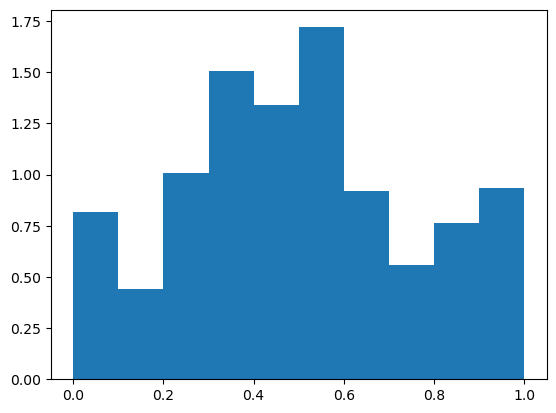

In [185]:
import warnings
warnings.filterwarnings("ignore")
train, valid, output = preprocessing()
pred = ncf_model(train, valid, lr = .0175,  epoch = 2)
pred2 = dlrm(train, valid)
plt.hist(pred2, density = True)
plt.show()

In [186]:
s = valid.head(-1)
s['predicted_values'] = pred2[:-1]

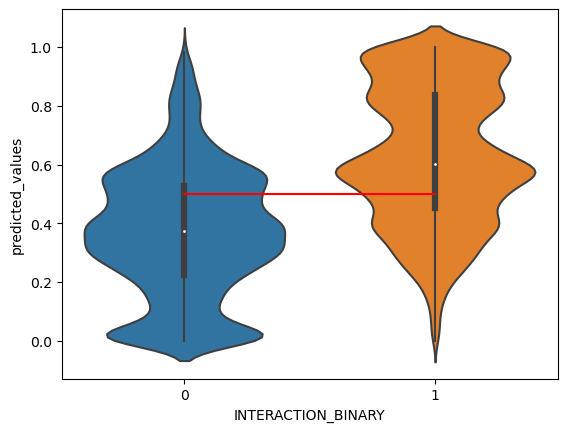

In [187]:
import seaborn as sns

sns.violinplot(data = s, x = 'INTERACTION_BINARY', y = 'predicted_values')
sns.lineplot(data = s, x = 'INTERACTION_BINARY', y = .5, color = 'r')

plt.show()

In [188]:
import sklearn

false_pos, true_pos, _ = sklearn.metrics.roc_curve(s['INTERACTION_BINARY'], s['predicted_values'])

<Axes: >

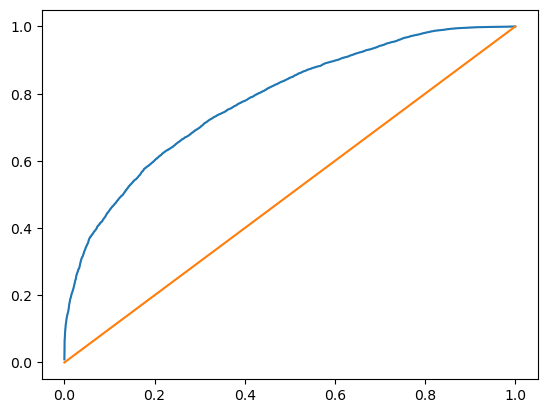

In [190]:
sns.lineplot(x = false_pos, y = true_pos)
sns.lineplot(x = false_pos, y = false_pos)

In [161]:
from merlin.models.utils.dataset import unique_rows_by_features

candidate_features = unique_rows_by_features(train, Tags.ITEM, Tags.ITEM_ID)
candidate_features.head()

,ITEM_ID,STYLE,TAXONOMY_STYLE,COLOR_NAME,PRODUCT_SUBCLASS,TEAM,FRANCHISE,PRODUCT_GROUP
0,13,-0.717022,-0.655776,-0.815655,-0.603257,0.399469,-0.799885,-0.649354
1,47,-0.717022,-0.655776,-0.815655,-0.603257,0.399469,-0.799885,-0.649354
2,3,-0.790835,-0.766427,-0.897754,-0.603257,-0.943711,-0.507102,-0.649354
3,6,-0.790835,-0.766427,-0.733555,-0.603257,-0.943711,-0.507102,-0.649354
4,51,0.242544,0.229430,0.333738,-0.603257,-0.943711,0.664029,-0.649354


In [162]:
topk = 20
topk_model = model.to_top_k_encoder(candidate_features, k=topk, batch_size=128)

# we can set `metrics` param in the `compile(), if we want
topk_model.compile(run_eagerly=False)

AttributeError: 'Model' object has no attribute 'to_top_k_encoder'

In [155]:
eval_loader = mm.Loader(valid, batch_size=8, shuffle=False)
batch = next(iter(eval_loader))

In [158]:
batch[0]['USER_ID']

<tf.Tensor: shape=(8,), dtype=int32, numpy=
array([18387, 10155, 11093,     2, 12944,  8635,     2,     2],
      dtype=int32)>

In [159]:
topk_model(batch[0])

NameError: name 'topk_model' is not defined

In [153]:
from merlin.systems.dag.ops.tensorflow import PredictTensorflow
from merlin.systems.dag.ops.workflow import TransformWorkflow

nvt_wkflow = nvt.Workflow(output)

workflow =  nvt.Workflow(["ITEM_ID"] + (['ITEM_ID', 'STYLE', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP'] >> TransformWorkflow(nvt_wkflow.get_subworkflow("item")) >> PredictTensorflow(model.first.item_block())))
item_embeddings = workflow.fit_transform(Dataset(item_features)).to_ddf().compute()

ValueError: No subgraph named item. Options are: dict_keys([])

In [201]:
import pandas as pd
cwd = os.getcwd()
pd.read_parquet('integration/workflow/integration/workflow/unique.ITEM_ID.parquet', engine='pyarrow')

,ITEM_ID,ITEM_ID_size
3,color-womens-tree-breezers-jet-black,4009
4,color-mens-tree-runners-jet-black-black,3703
5,color-mens-wool-runners,2296
6,color-womens-tree-breezers-navy-night,2256
7,color-womens-tree-runners-jet-black-black,2210
...,...,...
436,color-womens-wool-dasher-fluffs-natural-white-...,1
437,color-womens-wool-cardi-nebula,1
438,color-womens-tree-loungers-peppercorn,1
439,color-mens-wool-pipers-dark-jungle-hazy-pine,1
